True

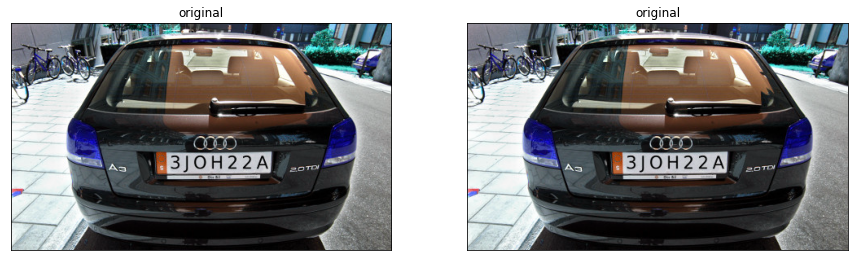

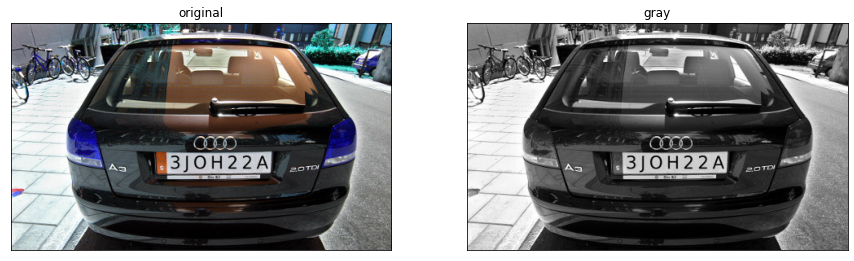

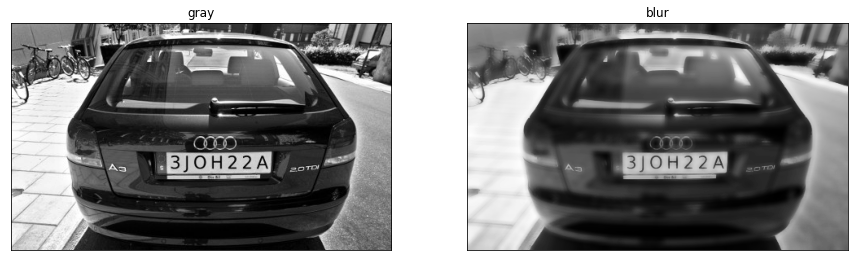

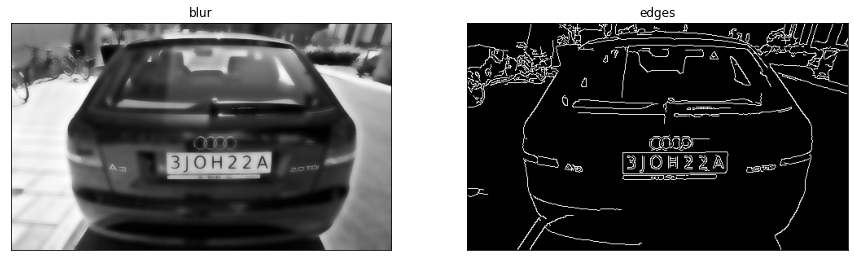

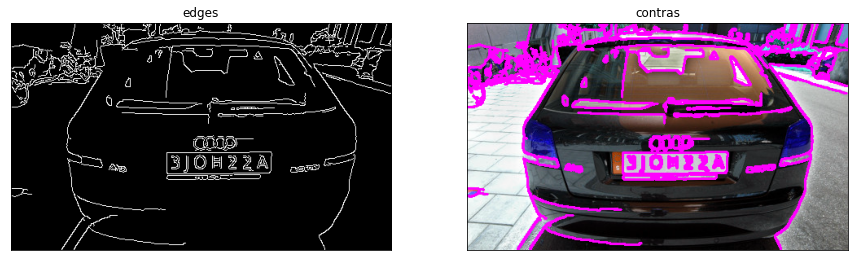

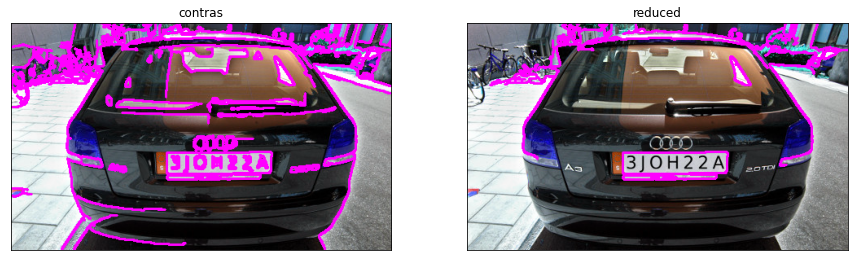

In [51]:
import cv2
import random
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def plot_images(img1, img2, title1="", title2=""):
    fig = plt.figure(figsize=[15,15])
    ax1 = fig.add_subplot(121)
    ax1.imshow(img1, cmap="gray")
    ax1.set(xticks=[], yticks=[], title=title1)

    ax2 = fig.add_subplot(122)
    ax2.imshow(img2, cmap="gray")
    ax2.set(xticks=[], yticks=[], title=title2)
     

path = "./car_1.jpg"

images = cv2.imread(path)

plot_images(images, images, title1='original', title2='original')

gray = cv2.cvtColor(images, cv2.COLOR_BGR2GRAY)

plot_images(images, gray,title1='original',title2='gray')

blur = cv2.bilateralFilter(gray, 11,90, 90)

plot_images(gray, blur, title1='gray',title2='blur')

edges = cv2.Canny(blur, 30, 200)

plot_images(blur, edges,title1='blur',title2='edges')


cnts, new = cv2.findContours(edges.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)


images_copy = images.copy()


_ = cv2.drawContours(images_copy, cnts, -1, (255,0,255),2)

plot_images(edges, images_copy, title1='edges',title2='contras')

cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:10]

image_reduced_cnts = images.copy()
_ = cv2.drawContours(image_reduced_cnts, cnts, -1, (255,0,255),2)


plot_images(images_copy, image_reduced_cnts, title1='contras', title2='reduced')


plate = None
for c in cnts:
    perimeter = cv2.arcLength(c, True)
    edges_count = cv2.approxPolyDP(c, 0.02 * perimeter, True)
    if len(edges_count) == 4:
        x,y,w,h = cv2.boundingRect(c)
        plate = images[y:y+h, x:x+w]
        break

cv2.imwrite("plate.png", plate)


In [52]:
def find_contours(dimensions, img) :

    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    
    # Check largest 5 or  15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    
    ii = cv2.imread('contour.jpg')
    
    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        #detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        #checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) #stores the x coordinate of the character's contour, to used later for indexing the contours

            char_copy = np.zeros((44,24))
            #extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            
            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            plt.imshow(ii, cmap='gray')

#             Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) #List that stores the character's binary image (unsorted)
            
    #Return characters on ascending order with respect to the x-coordinate (most-left character first)
            
    plt.show()
    #arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res


def segment_characters(image) :

    # Preprocess cropped license plate image
    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    # Make borders white
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
    plt.imshow(img_binary_lp, cmap='gray')
    plt.show()
    cv2.imwrite('contour.jpg',img_binary_lp)

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp)

    return char_list

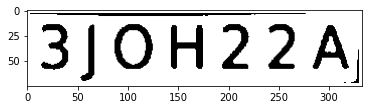

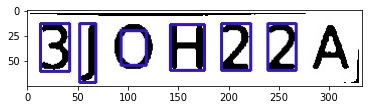

In [53]:
img = cv2.imread('plate.png')
char = segment_characters(img)

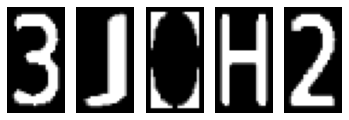

In [56]:
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(char[i], cmap='gray')
    plt.axis('off')

In [57]:
import tensorflow as tf

In [58]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [59]:
train_datagen = ImageDataGenerator(rescale=1./255, width_shift_range=0.1, height_shift_range=0.1)
train_generator = train_datagen.flow_from_directory(
        'data/data/train',  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28
        batch_size=1,
        class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
        'data/data/val',  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28        batch_size=1,
        class_mode='categorical')

Found 864 images belonging to 36 classes.
Found 216 images belonging to 36 classes.


In [60]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D
from tensorflow.keras import optimizers

In [61]:
model = Sequential()
model.add(Conv2D(32, (24,24), input_shape=(28, 28, 3), activation='relu', padding='same'))
# model.add(Conv2D(32, (20,20), input_shape=(28, 28, 3), activation='relu', padding='same'))
# model.add(Conv2D(32, (20,20), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(36, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=0.00001), metrics=['accuracy'])

class stop_training_callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.992):
      self.model.stop_training = True
    

In [62]:
import datetime
!rm -rf logs
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [63]:
batch_size = 1
callbacks = [tensorboard_callback, stop_training_callback()]
model.fit_generator(
      train_generator,
      steps_per_epoch = train_generator.samples // batch_size,
      validation_data = validation_generator, 
      validation_steps = validation_generator.samples // batch_size,
      epochs = 10, callbacks=callbacks)

Epoch 1/10
864/864 [==============================] - 13s 16ms/step - loss: 3.5296 - accuracy: 0.0764 - val_loss: 3.4010 - val_accuracy: 0.2361
Epoch 2/10
864/864 [==============================] - 14s 16ms/step - loss: 3.2020 - accuracy: 0.2199 - val_loss: 2.8833 - val_accuracy: 0.4676
Epoch 3/10
864/864 [==============================] - 13s 15ms/step - loss: 2.6582 - accuracy: 0.3715 - val_loss: 2.3569 - val_accuracy: 0.5602
Epoch 4/10
864/864 [==============================] - 13s 16ms/step - loss: 2.1194 - accuracy: 0.4838 - val_loss: 1.8462 - val_accuracy: 0.6343
Epoch 5/10
864/864 [==============================] - 13s 15ms/step - loss: 1.7085 - accuracy: 0.5625 - val_loss: 1.5323 - val_accuracy: 0.6852
Epoch 6/10
864/864 [==============================] - 13s 16ms/step - loss: 1.4423 - accuracy: 0.6181 - val_loss: 1.3223 - val_accuracy: 0.6852
Epoch 7/10
864/864 [==============================] - 14s 16ms/step - loss: 1.2829 - accuracy: 0.6539 - val_loss: 1.1349 - val_accuracy:

In [64]:
%load_ext tensorboard
%tensorboard --logdir logs/fit

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6007 (pid 65696), started 0:19:25 ago. (Use '!kill 65696' to kill it.)

In [65]:
def fix_dimension(img): 
  new_img = np.zeros((28,28,3))
  for i in range(3):
    new_img[:,:,i] = img
  return new_img

def show_results():
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i,c in enumerate(characters):
        dic[i] = c

    output = []
    for i,ch in enumerate(char): #iterating over the characters
        img_ = cv2.resize(ch, (28,28))
        img = fix_dimension(img_)
        img = img.reshape(1,28,28,3) #preparing image for the model
        y_ = model.predict_classes(img)[0] #predicting the class
        character = dic[y_] #
        output.append(character) #storing the result in a list
        
    plate_number = ''.join(output)
    
    return plate_number

print(show_results())

3JUH22


In [67]:
import csv2

ModuleNotFoundError: No module named 'csv2'